# Optimizing the weight of new data

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scoring_rules
import utility
import scipy.optimize
import random
random.seed(123)

### Data input

In [2]:
# Read in experimental oberauer data
# It consists of participants' answers to two abstract conditionals
patterns = pd.read_csv('../conditional_data/oberauer_81_patterns.csv')
patterns = patterns.drop(patterns.columns[0], axis=1)

# Transform counts into individual responses
data = []
for pattern in patterns.columns:
    frequency = patterns.loc[0, pattern]
    data += [[int(pattern[i]) for i in range(len(pattern))]] * frequency
data = pd.DataFrame(np.array(data), columns=['MP', 'MT', 'AC', 'DA'])

# Read in pre-formatted experimental data from Julia Wertheim's web-experiment
# Data consist of participants' answers to three everyday conditionals with lentils, peas etc.
julia_data = pd.read_csv('data/deduction_individual_responses.csv', sep=',').set_index('token')

In [3]:
julia_data

,MP,MT,AC,DA
token,,,,
0I2kyX7,3,3,1,3
0iEtfX6,3,3,3,3
1WZxpN9,3,2,2,2
3UlceN0,3,2,3,1
3euCGN5,3,0,3,1
3m2Z0N3,3,3,3,2
444XzV1,3,3,1,0
4Lc6R36,1,2,1,0
6CmEmN4,3,1,0,1


### Model imports

In [3]:
from uniform_model import UniformModel
from empirical_aggregate_model import EmpiricalAggregate
from generic_mpt_model import GenericMPT
from chater_oaksford_model import ChaterOaksford
from independence_model import IndependenceModel
from dependence_model import DependenceModel
from adaptive_chater_oaksford_model import AdaptiveChaterOaksford
print('importing done.')

importing done.


## Individualistic Evaluation
* Iterate over all participants
    * For every participant, let every model predict the response
    * Save the score the model archieved
    * Then tell the model the actual resonse
* Evaluate the complete prediction-answer set

In [44]:
THIN = 1

# Baseline Models
#models = [UniformModel(), EmpiricalAggregate()]
#models += [DependenceModel(), IndependenceModel(), GenericMPT()]
#models += [AdaptiveChaterOaksford(model_name=str(i), weight = i) for i in [0, 1, 2]]

def init_models():
    '''Initialize adaptive models with different weights'''
    models = []
    models += [AdaptiveChaterOaksford(model_name=str(i), weight = i) for i in np.arange(0, 5, 0.2)]
    return models

models = init_models()

modi = data.columns

selected_scoring_rules = {'Quadratic': scoring_rules.quad_score, 
                          'Logarithmic': scoring_rules.mean_log_score,                                                 
                          'Accuracy': scoring_rules.mean_accuracy,
                          'MRR': scoring_rules.mrr_score}


modi = list(data.columns)

#datasets = {'julia_webxp': julia_data, 'oberauer': data}
datasets = {'julia_webxp': julia_data}#, 'oberauer': data}

numeric_scores = dict()
for data_name, data_set in datasets.items():
    numeric_scores[data_name] = pd.DataFrame(0.0, columns=['Accuracy', 'MRR', 'Quadratic', 'Logarithmic'], 
                                             index=[model.__name__ for model in models])
    
    print('Dataset: {}, answers: {}'.format(data_name, data_set.max().max()))
    working_data = data_set.copy()

    # Iterate over participants
    for row in range(0, data_set.shape[0], THIN):
        
        # Re-initialize models to remove leftover information
        models = init_models()
        # Fit models to aggregate dataset
        for model in models:
            model.fit(dataset=data_set)

        # Iterate over all four modi MP, MT, AC, DA
        answers = []
        for modus in modi:
            for answer_number in range(0, data_set.max().max()):
                if working_data[modus][row] > 0:
                    answer = (modus, True)
                else:
                    answer = (modus, False)
                answers += [answer]
                
                # remember that this answer is already saved
                working_data[modus][row] -= 1                    
                    
        # Shuffle answers to remove sorting information
        random.shuffle(answers)
        for answer in answers:
            modus = answer[0]
            # Transform answer frequency to [yes, no]
            truth = np.array([[0, 0]])
            if answer[1]:
                truth[0, 0] = 1
            else:
                truth[0, 1] = 1

            # Let all models predict the answer
            for model in models:
                prediction = model.predict(modus)
                # Transform to format [accept, reject]
                prediction = np.array([[prediction, 1 - prediction]])

                # Rate the prediction with all scoring rules
                for rule_name, scoring_rule in selected_scoring_rules.items():
                    numeric_scores[data_name][rule_name][model.__name__] += scoring_rule(np.array(prediction), truth)

                # tell the model what actually happened
                model.feedback(problem=modus, answer=truth[0, 0])

        print('Progress: {} / {}'.format(row, data_set.shape[0]), end='\r')
    print()

    # Divide the scores by the number of participants sampled
    numeric_scores[data_name] /= (data_set.shape[0] / THIN)
    # Divide the scores by the number of answers given per participant (8)
    numeric_scores[data_name] /= (data_set.max().max() * data_set.shape[1])    

Dataset: julia_webxp, answers: 3
Progress: 48 / 49


0.0    0.637755
0.2    0.645408
0.4    0.681973
0.6    0.714286
0.8    0.709184
1.0    0.716837
1.2    0.715986
1.4    0.721939
1.6    0.719388
1.8    0.715986
2.0    0.717687
2.2    0.715986
2.4    0.715986
2.6    0.715986
2.8    0.717687
3.0    0.715986
3.2    0.715986
3.4    0.715986
3.6    0.715986
3.8    0.717687
4.0    0.717687
4.2    0.717687
4.4    0.719388
4.6    0.719388
4.8    0.719388
Name: Accuracy, dtype: float64

Text(0.5,0,'Weighting factor new/old data')

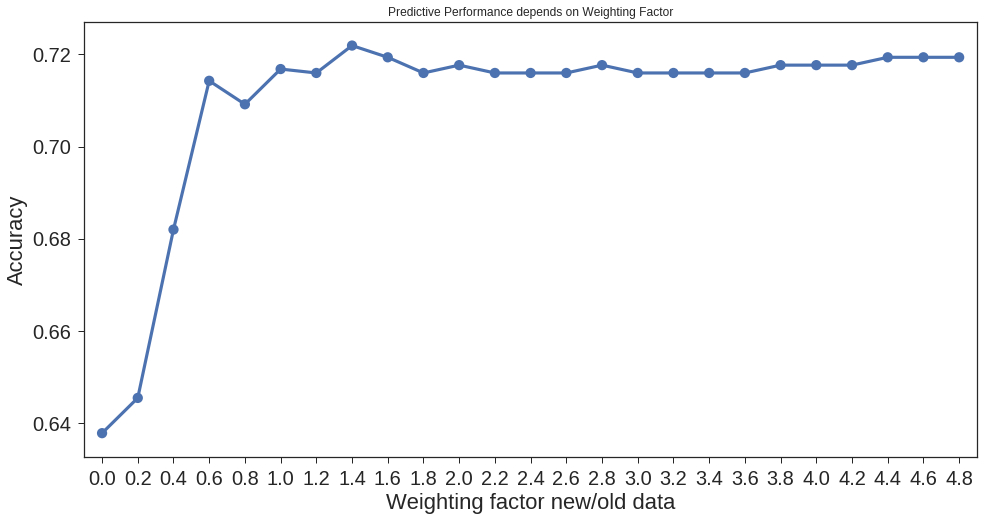

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.set(style='ticks', font_scale=1)
df = numeric_scores['julia_webxp']
acc = df['Accuracy']
display(acc)
pl = sns.pointplot(y=acc, x=acc.index, ax=ax)
#pl.set_xticklabels(pl.get_xticklabels(), rotation=20)
pl.set_ylabel('Accuracy')
pl.set_title('Predictive Performance depends on Weighting Factor')
pl.set_xlabel('Weighting factor new/old data')

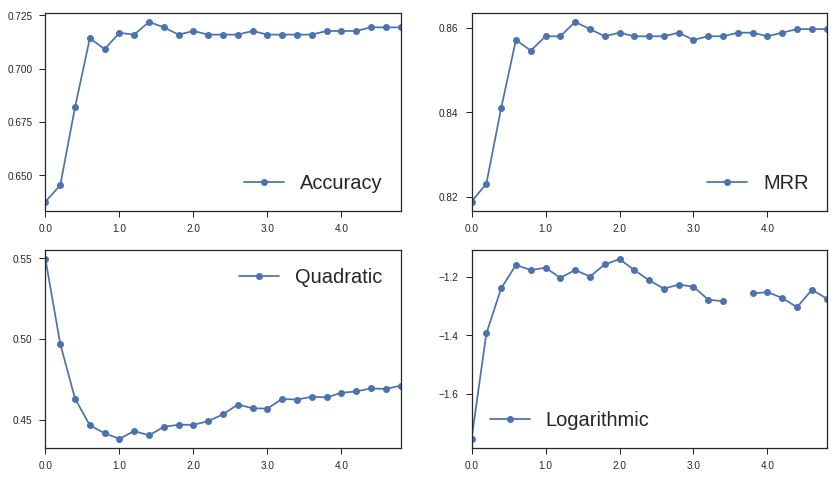

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))
sns.set(style='ticks', font_scale=2)

legend = []
for data_name, data_set in datasets.items():
    i = 0
    for rule_name in numeric_scores[data_name].columns:
        axis = ax[i // 2, i % 2]
        a = numeric_scores[data_name][rule_name].plot(style='o-', rot=0, ax=axis, legend=True)
        #axis.set_ylabel(rule_name)
        i += 1
    legend += [data_name]
    
plt.show() 

### Conclusion
I have done a gridsearch on possible old/new empirical data weighting strategies.
* There seems to be a quasi-optimal value for (*Accuracy, MRR, Quad*) but it is not optimal for *Log*
* This is weird as both Quda and Log are strictly proper scoring rules
* The score-weight landscape is not very smooth, there are spikes